# Go from exponential to Poisson


In [209]:
%matplotlib inline

from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as mc
import spacepy.toolbox as tb
import spacepy.plot as spp
import tqdm
from scipy import stats
import seaborn as sns
sns.set(font_scale=1.5)
# matplotlib.pyplot.rc('figure', figsize=(10,10))
# matplotlib.pyplot.rc('lines', lw=3)
# matplotlib.pyplot.rc('font', size=20)



%matplotlib inline

## Generate Poisson process data and generate exponential

For each interval choose $n$ events from a Poisson. Then draw from a uniform the location in the interval for each of the events.

In [210]:
np.random.seed(8675309)
nT = 400
cts = np.random.poisson(20, size=nT)
edata = []
for i in range(nT):
    edata.extend(i + np.sort(np.random.uniform(low=0, high=1, size=cts[i])))
edata = np.asarray(edata)
edata.shape

(7933,)

Text(0.5,1,'Modeled underlying data')

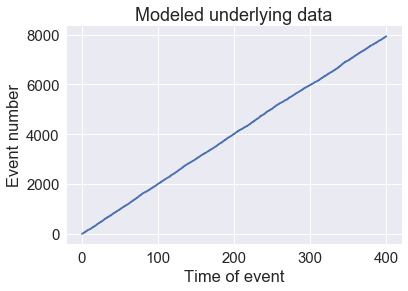

In [211]:
plt.plot(edata, np.arange(len(edata)))
plt.xlabel('Time of event')
plt.ylabel('Event number')
plt.title("Modeled underlying data")

In [212]:
with mc.Model() as model:
    lam = mc.Uniform('lambda', 0, 1000)  # this is the exponential parameter
    meas = mc.Exponential('meas', lam, observed=np.diff(edata))
    lam2 = mc.Uniform('lam2', 0, 1000)
    poi = mc.Poisson('Poisson', lam2, observed=cts)
    start = mc.find_MAP()
    trace = mc.sample(10000, start=start, njobs=8)

Optimization terminated successfully.
         Current function value: -14603.719126
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -14,453:   9%|▊         | 17082/200000 [00:07<01:18, 2339.91it/s]  
Convergence archived at 17100
Interrupted at 17,100 [8%]: Average Loss = 60,831
100%|██████████| 10500/10500 [00:23<00:00, 443.73it/s]



lambda:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  19.834           0.221            0.001            [19.405, 20.271]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  19.404         19.684         19.834         19.984         20.270


lam2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  19.835           0.223            0.001            [19.400, 20.270]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  19.402         19.683         19.835         19.984         20.273



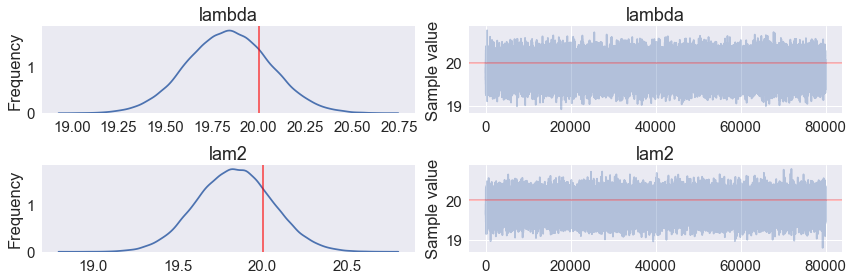

In [213]:
mc.traceplot(trace, combined=True, lines={'lambda':20, 'lam2':20})
mc.summary(trace)

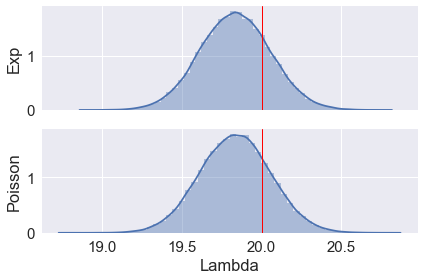

In [214]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
sns.distplot(trace['lambda'], ax=ax[0])
sns.distplot(trace['lam2'], ax=ax[1])
plt.xlabel('Lambda')
ax[0].set_ylabel('Exp')
ax[1].set_ylabel('Poisson')
ax[0].axvline(20, c='r', lw=1)
ax[1].axvline(20, c='r', lw=1)
plt.tight_layout()

This is consistent with a Poisson of parameter 20! But there seems to be an under prediction going on, wonder why?

Go through Posterior Predictive Checks (http://docs.pymc.io/notebooks/posterior_predictive.html) and see if we are reprodicting the mean and variance. 


In [215]:
ppc = mc.sample_ppc(trace, samples=500, model=model, size=100)


100%|██████████| 500/500 [00:00<00:00, 3397.23it/s]


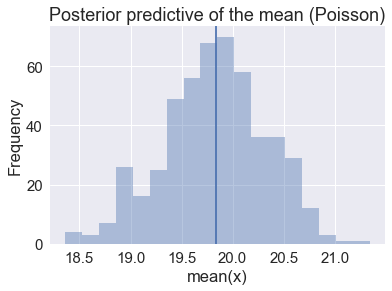

In [216]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc['Poisson']], kde=False, ax=ax)
ax.axvline(cts.mean())
ax.set(title='Posterior predictive of the mean (Poisson)', xlabel='mean(x)', ylabel='Frequency');

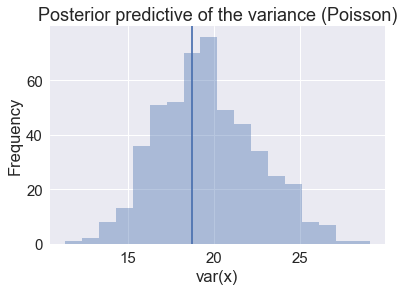

In [217]:
ax = plt.subplot()
sns.distplot([n.var() for n in ppc['Poisson']], kde=False, ax=ax)
ax.axvline(cts.var())
ax.set(title='Posterior predictive of the variance (Poisson)', xlabel='var(x)', ylabel='Frequency');

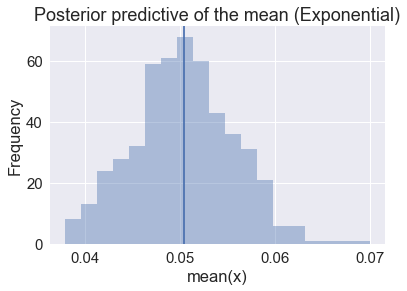

In [218]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc['meas']], kde=False, ax=ax)
ax.axvline(np.diff(edata).mean())
ax.set(title='Posterior predictive of the mean (Exponential)', xlabel='mean(x)', ylabel='Frequency');

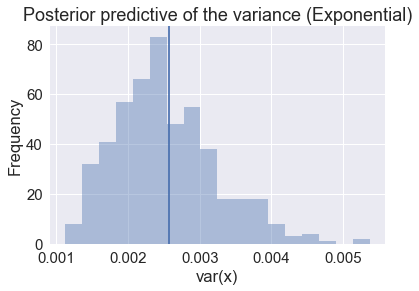

In [219]:
ax = plt.subplot()
sns.distplot([n.var() for n in ppc['meas']], kde=False, ax=ax)
ax.axvline(np.diff(edata).var())
ax.set(title='Posterior predictive of the variance (Exponential)', xlabel='var(x)', ylabel='Frequency');

We are reprodicting well. 

## Given the data we generated that will be treated as truth, what would we measure with various deadtime and does teh corection match what we think it should?

Correction should look like $n_1 = \frac{R_1}{1-R_1 \tau}$ where $n_1$ is real rate, $R_1$ is observed rate, and $\tau$ is the dead time. 

Take edata from above and strep through from beginning to end only keeping points that are dead time away from the previous point. 

In [220]:
deadtime1 = 0.005 # small dead time
deadtime2 = 0.1   # large dead time

edata_td1 = []
edata_td1.append(edata[0])
edata_td2 = []
edata_td2.append(edata[0])

for ii, v in enumerate(edata[1:], 1):  # stop one shy to not run over the end, start enumerate at 1
    if v - edata_td1[-1] >= deadtime1:
        edata_td1.append(v)
    if v - edata_td2[-1] >= deadtime2:
        edata_td2.append(v)
    
edata_td1 = np.asarray(edata_td1)    
edata_td2 = np.asarray(edata_td2)    
    




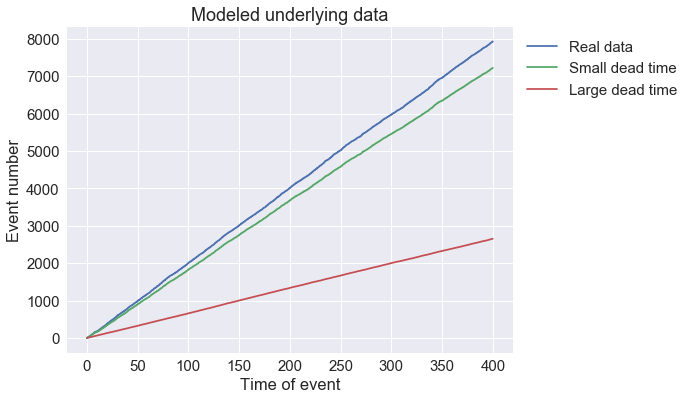

In [221]:
plt.figure(figsize=(8,6))
plt.plot(edata, np.arange(len(edata)), label='Real data')

plt.plot(edata_td1, np.arange(len(edata_td1)), label='Small dead time')
plt.plot(edata_td2, np.arange(len(edata_td2)), label='Large dead time')

plt.xlabel('Time of event')
plt.ylabel('Event number')
plt.title("Modeled underlying data")

plt.legend(bbox_to_anchor=(1, 1))

### And plot the rates per unit time

Text(0.5,0,'Time')

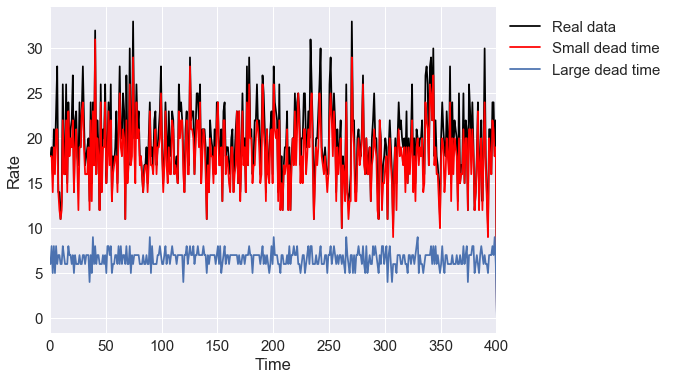

In [222]:
plt.figure(figsize=(8,6))
h1, b1 = np.histogram(edata, np.arange(1000))
plt.plot(tb.bin_edges_to_center(b1), h1, label='Real data', c='k')

h2, b2 = np.histogram(edata_td1, np.arange(1000))
plt.plot(tb.bin_edges_to_center(b2), h2, label='Small dead time', c='r')

h3, b3 = np.histogram(edata_td2, np.arange(1000))
plt.plot(tb.bin_edges_to_center(b3), h3, label='Large dead time')


plt.legend(bbox_to_anchor=(1, 1))
plt.xlim((0,400))
plt.ylabel('Rate')
plt.xlabel('Time')

## Can we use $n_1 = \frac{R_1}{1-R_1 \tau}$ to derive the relation and spread in the dist of R?

Algerbra changes math to: $R_1=\frac{n_1}{1+n_1\tau}$

### Use the small dead time

In [223]:
# assume R1 is Poisson

with mc.Model() as model:
    tau = deadtime1
    obsRate = mc.Uniform('obsRate', 0, 1000, shape=1)
    obsData = mc.Poisson('obsData', obsRate, observed=h2[:400], shape=1)
    realRate = mc.Deterministic('realRate', obsData/(1-obsData*tau))
    start = mc.find_MAP()
    trace = mc.sample(10000, start=start, njobs=8)

Optimization terminated successfully.
         Current function value: 1097.694313
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 8,491.2:   5%|▍         | 9927/200000 [00:03<01:07, 2799.35it/s]   
Convergence archived at 10200
Interrupted at 10,200 [5%]: Average Loss = 65,144
100%|██████████| 10500/10500 [00:15<00:00, 684.04it/s]



obsRate:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  18.063           0.213            0.001            [17.639, 18.474]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  17.648         17.918         18.063         18.206         18.485



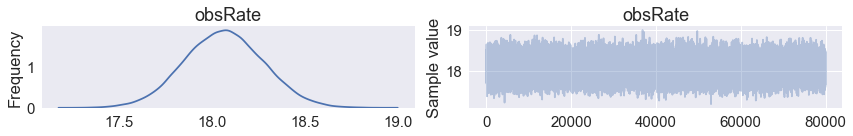

In [224]:
mc.traceplot(trace, combined=True, varnames=('obsRate', ))
mc.summary(trace, varnames=('obsRate', ))

The estimate of the real rate given that we know the dead time is: [ 11.64021164  19.78021978  29.88505747] 0.922378317014
This compares with if we measured without dead time as: [ 11.975  20.     29.   ] 0.85125


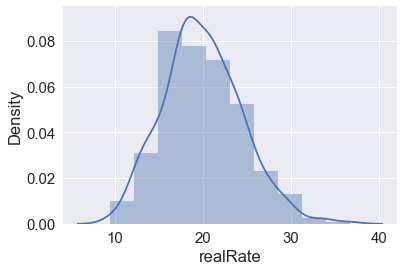

In [225]:
sns.distplot(trace['realRate'].mean(axis=0), bins=10)
plt.xlabel('realRate')
plt.ylabel('Density')

dt1_bounds = np.percentile(trace['realRate'], (2.5, 50, 97.5))
print('The estimate of the real rate given that we know the dead time is:', dt1_bounds, 
      (dt1_bounds[2]-dt1_bounds[0])/dt1_bounds[1])

dat_bounds = np.percentile(h1[:400], (2.5, 50, 97.5))
print("This compares with if we measured without dead time as:", dat_bounds, 
      (dat_bounds[2]-dat_bounds[0])/dat_bounds[1])



### Use the large dead time

In [226]:
# assume R1 is Poisson

with mc.Model() as model:
    tau = deadtime2
    obsRate = mc.Uniform('obsRate', 0, 1000)
    obsData = mc.Poisson('obsData', obsRate, observed=h3[:400])
    realRate = mc.Deterministic('realRate', obsData/(1-obsData*tau))
    start = mc.find_MAP()
    trace = mc.sample(10000, start=start, njobs=8)

Optimization terminated successfully.
         Current function value: 780.075528
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 16,366:   5%|▍         | 9784/200000 [00:03<01:05, 2900.57it/s]    
Convergence archived at 9900
Interrupted at 9,900 [4%]: Average Loss = 78,517
100%|██████████| 10500/10500 [00:15<00:00, 688.92it/s]



obsRate:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  6.644            0.129            0.001            [6.395, 6.901]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  6.393          6.557          6.644          6.731          6.899



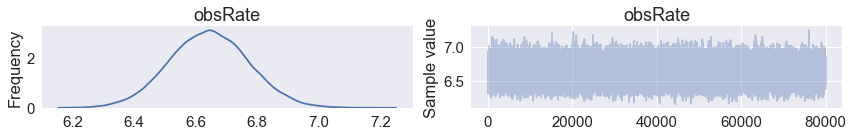

In [227]:
mc.traceplot(trace, combined=True, varnames=('obsRate', ))
mc.summary(trace, varnames=('obsRate', ))

The estimate of the real rate given that we know the dead time is: [ 11.64021164  19.78021978  29.88505747] 1.28571428571
This compares with if we measured without dead time as: [ 11.975  20.     29.   ] 0.85125


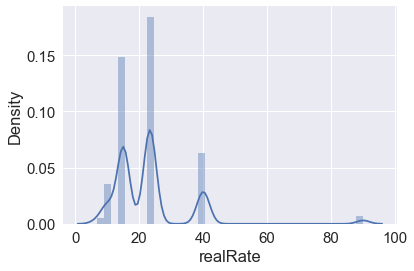

In [228]:
sns.distplot(trace['realRate'].mean(axis=0))
plt.xlabel('realRate')
plt.ylabel('Density')

dt2_bounds = np.percentile(trace['realRate'], (2.5, 50, 97.5))
print('The estimate of the real rate given that we know the dead time is:', dt1_bounds, 
      (dt2_bounds[2]-dt2_bounds[0])/dt2_bounds[1])

dat_bounds = np.percentile(h1[:400], (2.5, 50, 97.5))
print("This compares with if we measured without dead time as:", dat_bounds, 
      (dat_bounds[2]-dat_bounds[0])/dat_bounds[1])



But this is totally broken!!!

# Output data files for each

In [230]:
real = pd.Series(edata)
td1 = pd.Series(edata_td1)
td2 = pd.Series(edata_td2)

real.to_csv('no_deadtime_times.csv')
td1.to_csv('small_deadtime_times.csv')
td2.to_csv('large_deadtime_times.csv')



In [231]:
real = pd.Series(h1[h1>0])
td1 = pd.Series(h2[h2>0])
td2 = pd.Series(h3[h3>0])

real.to_csv('no_deadtime_rates.csv')
td1.to_csv('small_deadtime_rates.csv')
td2.to_csv('large_deadtime_rates.csv')